In [50]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [51]:
# coding=utf-8

# Author: Alceu Britto
#

!pip install deslib

import lib_analise
import matplotlib.pyplot as plt
import matplotlib as pl
from matplotlib.ticker import FuncFormatter
from matplotlib.cm import get_cmap
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from deslib.util.datasets import make_P2
from sklearn.model_selection import GridSearchCV
from sklearn import manifold, datasets
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits, load_breast_cancer, load_iris
import itertools
import pandas as pd
import seaborn as sns
import urllib
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

Defaulting to user installation because normal site-packages is not writeable


In [52]:
#variaveis globais
import lib_analise 
info_modelo = lib_analise.get_info_modelo()  # para garantir que a função está carregada da
nome_dataset = info_modelo['nome_dataset']
arq_dataset_csv = info_modelo['parametros']['arq_dataset_csv']
arq_dataset_pkl = info_modelo['parametros']['arq_dataset_pkl']
print(nome_dataset)

svm


In [53]:
# Plotting the confusion matrix
def plot_confusion_matrix(ax, cm, title=None):

    df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"])
    sns.heatmap(df_cm, annot=True)
    ax.set_title('Confusion Matrix --> ' + title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return ax

In [54]:
# Plotting-related functions
def make_grid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


In [55]:
# Plotting the dataset

def plot_dataset(X, y, ax=None, title=None, **params):

    X_t=pd.DataFrame(X)
    y=pd.DataFrame(y)
    XY=pd.concat([X_t,y], axis=1)
    XY.columns = ['x', 'y', 'digit']

    customPalette=sns.hls_palette(10, l=.7, s=1)

    ax.set_xlim(XY['x'].min()*0.98,XY['x'].max()*1.02)
    ax.set_ylim(XY['y'].min()*0.98,XY['y'].max()*1.02)

    for i in range(0,10):
        k=0
        for l, row in XY.loc[XY['digit']==i,:].iterrows():
            if k==0:
                ax.plot(row['x'], row['y'], '.', color=customPalette[i], label=int(row['digit']))
                ax.legend(numpoints=1, markerscale=3, loc='upper right', bbox_to_anchor=(1.2, 1.0))
                k += 1
            ax.annotate(int(row['digit']), (row['x'], row['y']), horizontalalignment='center', verticalalignment='center', size=10, color=customPalette[i])
            ax.set_title(title, fontsize=15)

    return ax

In [56]:
# Plotting the Classifier Decision

def plot_classifier_decision(ax, clf, X, X_embedded, mode='line', **params):

# create meshgrid
    resolution = 200 # 100x100 background pixels
    y_predicted = clf.predict(X);
    X2d_xmin, X2d_xmax = np.min(X_embedded[:,0]), np.max(X_embedded[:,0])
    X2d_ymin, X2d_ymax = np.min(X_embedded[:,1]), np.max(X_embedded[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X_embedded, y_predicted)
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
    ax.contourf(xx, yy, voronoiBackground, levels=10, cmap="RdBu_r")
    plot_dataset(X_embedded, y_predicted, ax, 'teste', **params)

    return ax


In [57]:
# Loading datasets
rng = np.random.RandomState(123)

datasets = lib_analise.get_dataset_analise(analise_ganho_de_informacao=True)
X_train = datasets['X_train']
X_test = datasets['X_test']
X_val = datasets['X_val']

y_train = datasets['y_train']
y_test = datasets['y_test']
y_val = datasets['y_val']
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(32259, 2)
(24194, 2)
(24195, 2)


In [58]:
# Define single classifiers (monolithic Classifiers)

dt =  DecisionTreeClassifier(criterion='entropy')
knn = KNeighborsClassifier(n_neighbors=3)
knnw = KNeighborsClassifier(n_neighbors=3, weights='distance')
mlp = MLPClassifier(solver='lbfgs', early_stopping=True, hidden_layer_sizes=(32), activation='logistic', batch_size=100, max_iter=10000, learning_rate_init=0.001, momentum=0.8, random_state=46)
nb = GaussianNB(var_smoothing=1e-09)

# parameters for SVM
parameters = [
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'kernel': ['poly']},
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'gamma': [0.1, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
]
svm = SVC(gamma='scale', probability=True, random_state=42)
svm = GridSearchCV(svm, parameters, scoring = 'accuracy', cv=10)

# Define ensembles (homogeneous and heterogeneous)
rf = RandomForestClassifier(n_estimators=100, random_state=0)
cb = VotingClassifier(estimators=[('DecisionTree', dt), ('NaiveBayes', nb), ('knn', knn)], voting='soft')
bg = BaggingClassifier(estimator=knn, n_estimators=100, random_state=0)
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
xgboost = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

#titles = ['DecisionTree', 'KNN', 'KNN_W', 'NaiveBayes', 'MLP', 'SVM', 'RF', 'DT+NB+KNN', 'Bag', 'Ada', 'XGBoost']
#methods = [dt, knn, knnw, nb, mlp, svm, rf, cb, bg, ada, xgboost]

titles = ['DecisionTree', 'RF', 'KNN', 'NaiveBayes', 'MLP', 'XGBoost','ADA','DT+NB+KNN']
methods = [dt, rf, knn, nb, mlp, xgboost,ada,cb]





In [59]:
# Fit the classifiers
scores = []
for method, name in zip(methods, titles):
    method.fit(X_train, y_train)
    scores.append(method.score(X_test, y_test))
    print("Classification accuracy {} = {}"
          .format(name, method.score(X_test, y_test)))


Classification accuracy DecisionTree = 0.9930561296189138
Classification accuracy RF = 0.9932214598660825
Classification accuracy KNN = 0.9922294783830702
Classification accuracy NaiveBayes = 0.8434322559312226
Classification accuracy MLP = 0.56617343142928
Classification accuracy RF = 0.9932214598660825
Classification accuracy KNN = 0.9922294783830702
Classification accuracy NaiveBayes = 0.8434322559312226
Classification accuracy MLP = 0.56617343142928
Classification accuracy XGBoost = 0.9900388526080847
Classification accuracy XGBoost = 0.9900388526080847
Classification accuracy ADA = 0.989873522360916
Classification accuracy DT+NB+KNN = 0.9926841365627842
Classification accuracy ADA = 0.989873522360916
Classification accuracy DT+NB+KNN = 0.9926841365627842


In [60]:
# Geração de Dataset com Métricas de Avaliação dos Modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import os
from datetime import datetime

print("📊 Gerando dataset com métricas de avaliação dos modelos...")

# Lista para armazenar as métricas
metrics_data = []

# Iterar por todos os modelos treinados
for clf, title in zip(methods, titles):
    print(f"🔍 Avaliando modelo: {title}")
    
    try:
        # Fazer predições no conjunto de teste
        y_pred = clf.predict(X_test)
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Adicionar dados à lista
        metrics_data.append({
            'modelo': title,
            'acuracia': accuracy,
            'precisao': precision,
            'recall': recall,
            'f1_score': f1,
            'dataset': nome_dataset,
            'data_avaliacao': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })
        
        print(f"   ✅ {title}: Acurácia={accuracy:.4f}, Precisão={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        
    except Exception as e:
        print(f"   ❌ Erro ao avaliar {title}: {e}")
        
        # Adicionar dados com erro
        metrics_data.append({
            'modelo': title,
            'acuracia': None,
            'precisao': None,
            'recall': None,
            'f1_score': None,
            'dataset': nome_dataset,
            'data_avaliacao': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })

# Criar DataFrame com as métricas
metrics_df = pd.DataFrame(metrics_data)

# Exibir o dataset
print(f"\n📋 DATASET DE MÉTRICAS GERADO:")
print("=" * 80)
print(metrics_df.to_string(index=False, float_format='%.4f'))

# Estatísticas resumidas
print(f"\n📈 ESTATÍSTICAS RESUMIDAS:")
print("=" * 50)
if len(metrics_df[metrics_df['acuracia'].notna()]) > 0:
    valid_metrics = metrics_df[metrics_df['acuracia'].notna()]
    
    print(f"Número de modelos avaliados: {len(valid_metrics)}")
    print(f"Melhor acurácia: {valid_metrics['acuracia'].max():.4f} ({valid_metrics.loc[valid_metrics['acuracia'].idxmax(), 'modelo']})")
    print(f"Melhor precisão: {valid_metrics['precisao'].max():.4f} ({valid_metrics.loc[valid_metrics['precisao'].idxmax(), 'modelo']})")
    print(f"Melhor recall: {valid_metrics['recall'].max():.4f} ({valid_metrics.loc[valid_metrics['recall'].idxmax(), 'modelo']})")
    print(f"Melhor F1-Score: {valid_metrics['f1_score'].max():.4f} ({valid_metrics.loc[valid_metrics['f1_score'].idxmax(), 'modelo']})")
    
    print(f"\nMédia das métricas:")
    print(f"  Acurácia média: {valid_metrics['acuracia'].mean():.4f}")
    print(f"  Precisão média: {valid_metrics['precisao'].mean():.4f}")
    print(f"  Recall médio: {valid_metrics['recall'].mean():.4f}")
    print(f"  F1-Score médio: {valid_metrics['f1_score'].mean():.4f}")

# Salvar o dataset em arquivo CSV
dataset_dir = os.path.join('..', 'dataset')
os.makedirs(dataset_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
metrics_filename = f'metricas_modelos_{nome_dataset}_{timestamp}.csv'
metrics_filepath = os.path.join(dataset_dir, metrics_filename)

try:
    metrics_df.to_csv(metrics_filepath, index=False, encoding='utf-8')
    print(f"\n💾 Dataset salvo em: {metrics_filepath}")
    
    # Verificar o tamanho do arquivo
    file_size = os.path.getsize(metrics_filepath)
    print(f"📁 Tamanho do arquivo: {file_size} bytes ({file_size/1024:.2f} KB)")
    
except Exception as e:
    print(f"\n❌ Erro ao salvar dataset: {e}")

# Ranking dos modelos por acurácia
print(f"\n🏆 RANKING DOS MODELOS (por acurácia):")
print("=" * 60)
valid_models = metrics_df[metrics_df['acuracia'].notna()].copy()
if len(valid_models) > 0:
    valid_models_sorted = valid_models.sort_values('acuracia', ascending=False).reset_index(drop=True)
    
    for i, row in valid_models_sorted.iterrows():
        medal = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1:2d}."
        print(f"{medal} {row['modelo']:15s}: {row['acuracia']:6.4f} (Precisão: {row['precisao']:6.4f}, Recall: {row['recall']:6.4f}, F1: {row['f1_score']:6.4f})")

print(f"\n🎉 Análise completa! Dataset gerado com {len(metrics_df)} modelos.")

# Disponibilizar o DataFrame para uso posterior
print(f"\n💡 O DataFrame 'metrics_df' está disponível para análises adicionais.")

📊 Gerando dataset com métricas de avaliação dos modelos...
🔍 Avaliando modelo: DecisionTree
   ✅ DecisionTree: Acurácia=0.9931, Precisão=0.9931, Recall=0.9931, F1=0.9931
🔍 Avaliando modelo: RF
   ✅ RF: Acurácia=0.9932, Precisão=0.9933, Recall=0.9932, F1=0.9932
🔍 Avaliando modelo: KNN
   ✅ KNN: Acurácia=0.9922, Precisão=0.9923, Recall=0.9922, F1=0.9922
🔍 Avaliando modelo: NaiveBayes
   ✅ NaiveBayes: Acurácia=0.8434, Precisão=0.8454, Recall=0.8434, F1=0.8439
🔍 Avaliando modelo: MLP
   ✅ MLP: Acurácia=0.5662, Precisão=0.3206, Recall=0.5662, F1=0.4093
🔍 Avaliando modelo: XGBoost
   ✅ XGBoost: Acurácia=0.9900, Precisão=0.9901, Recall=0.9900, F1=0.9900
🔍 Avaliando modelo: ADA
   ✅ ADA: Acurácia=0.9899, Precisão=0.9899, Recall=0.9899, F1=0.9899
🔍 Avaliando modelo: DT+NB+KNN
   ✅ MLP: Acurácia=0.5662, Precisão=0.3206, Recall=0.5662, F1=0.4093
🔍 Avaliando modelo: XGBoost
   ✅ XGBoost: Acurácia=0.9900, Precisão=0.9901, Recall=0.9900, F1=0.9900
🔍 Avaliando modelo: ADA
   ✅ ADA: Acurácia=0.9899, P

🎯 Gerando Matrizes de Confusão para todos os modelos...
📊 Processando modelo 1/8: DecisionTree
   ✅ DecisionTree: Acurácia = 99.31%
📊 Processando modelo 2/8: RF
   ✅ DecisionTree: Acurácia = 99.31%
📊 Processando modelo 2/8: RF
   ✅ RF: Acurácia = 99.32%
📊 Processando modelo 3/8: KNN
   ✅ RF: Acurácia = 99.32%
📊 Processando modelo 3/8: KNN
   ✅ KNN: Acurácia = 99.22%
📊 Processando modelo 4/8: NaiveBayes
   ✅ NaiveBayes: Acurácia = 84.34%
📊 Processando modelo 5/8: MLP
   ✅ KNN: Acurácia = 99.22%
📊 Processando modelo 4/8: NaiveBayes
   ✅ NaiveBayes: Acurácia = 84.34%
📊 Processando modelo 5/8: MLP
   ✅ MLP: Acurácia = 56.62%
📊 Processando modelo 6/8: XGBoost
   ✅ MLP: Acurácia = 56.62%
📊 Processando modelo 6/8: XGBoost
   ✅ XGBoost: Acurácia = 99.00%
📊 Processando modelo 7/8: ADA
   ✅ XGBoost: Acurácia = 99.00%
📊 Processando modelo 7/8: ADA
   ✅ ADA: Acurácia = 98.99%
📊 Processando modelo 8/8: DT+NB+KNN
   ✅ ADA: Acurácia = 98.99%
📊 Processando modelo 8/8: DT+NB+KNN
   ✅ DT+NB+KNN: Acuráci

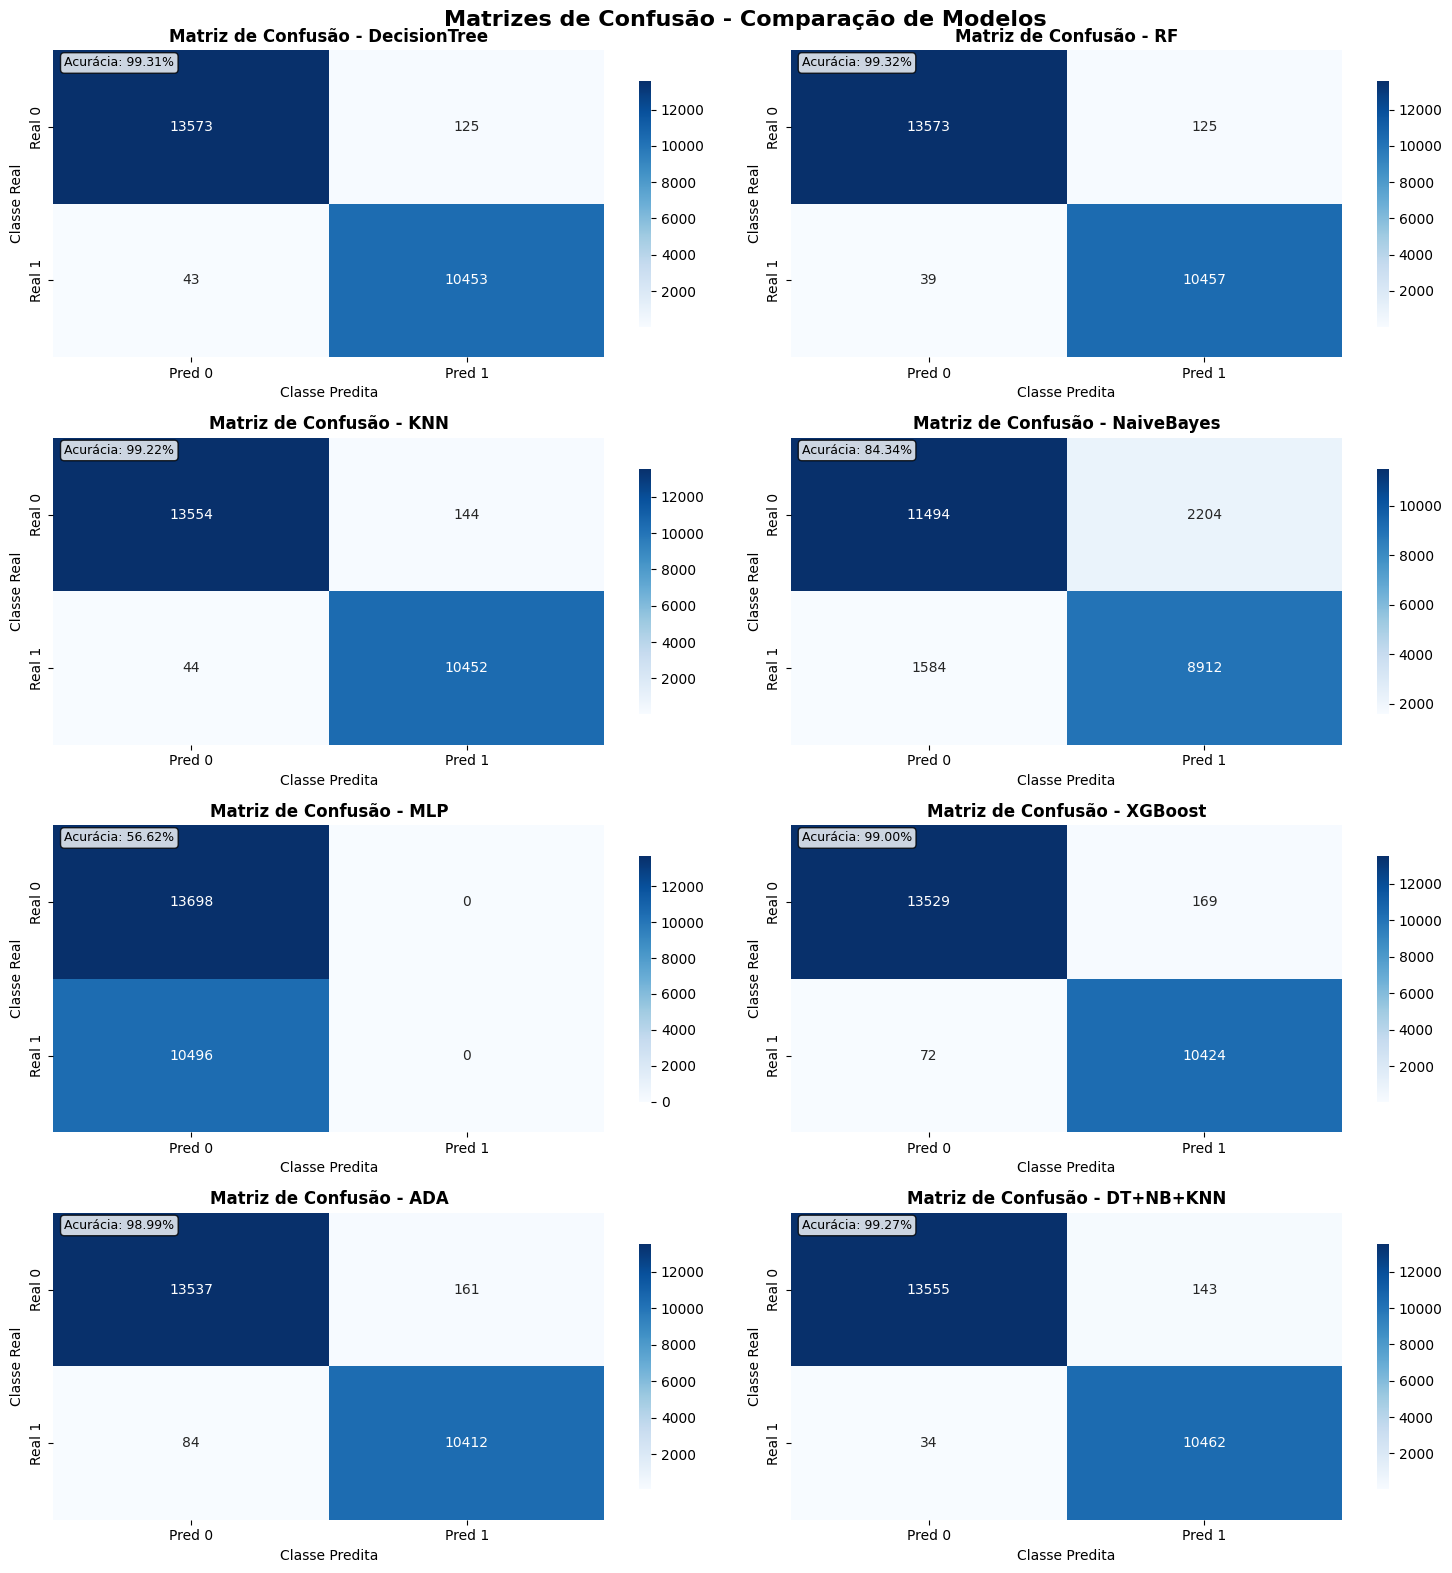


🎉 Matrizes de confusão geradas para 8 modelos!
📊 Layout: 4 linhas × 2 colunas

📈 RESUMO DAS ACURÁCIAS:
 1. DecisionTree   :  99.31%
 2. RF             :  99.32%
 3. KNN            :  99.22%
 4. NaiveBayes     :  84.34%
 5. MLP            :  56.62%
 6. XGBoost        :  99.00%
 7. ADA            :  98.99%
 8. DT+NB+KNN      :  99.27%
 8. DT+NB+KNN      :  99.27%


In [61]:
# Matriz de confusão (apenas para classificadores)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("🎯 Gerando Matrizes de Confusão para todos os modelos...")

# Calcular o número de linhas necessárias (2 colunas por linha)
n_models = len(methods)
n_rows = (n_models + 1) // 2  # Arredonda para cima

# Criar subplots com 2 colunas
fig3, axes = plt.subplots(n_rows, 2, figsize=(15, n_rows * 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Garantir que axes seja sempre um array 2D
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_models == 1:
    axes = axes.reshape(-1, 1)

# Iterar pelos modelos e plotar matrizes de confusão
for i, (clf, title) in enumerate(zip(methods, titles)):
    # Calcular posição na grade (linha, coluna)
    row = i // 2
    col = i % 2
    
    print(f"📊 Processando modelo {i+1}/{n_models}: {title}")
    
    try:
        # Fazer predições
        y_predicted = clf.predict(X_test)
        
        # Calcular matriz de confusão
        cm = confusion_matrix(y_test, y_predicted)
        
        # Plotar usando seaborn heatmap
        df_cm = pd.DataFrame(cm, 
                           index=[f'Real {i}' for i in range(len(cm))],
                           columns=[f'Pred {i}' for i in range(len(cm))])
        
        sns.heatmap(df_cm, 
                   annot=True, 
                   fmt='d', 
                   cmap='Blues',
                   ax=axes[row, col],
                   cbar_kws={'shrink': 0.8})
        
        axes[row, col].set_title(f'Matriz de Confusão - {title}', fontsize=12, fontweight='bold')
        axes[row, col].set_xlabel('Classe Predita', fontsize=10)
        axes[row, col].set_ylabel('Classe Real', fontsize=10)
        
        # Calcular e exibir métricas
        accuracy = (cm.diagonal().sum() / cm.sum()) * 100
        
        # Adicionar texto com acurácia
        axes[row, col].text(0.02, 0.98, f'Acurácia: {accuracy:.2f}%', 
                           transform=axes[row, col].transAxes,
                           verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           fontsize=9)
        
        print(f"   ✅ {title}: Acurácia = {accuracy:.2f}%")
        
    except Exception as e:
        print(f"   ❌ Erro ao processar {title}: {e}")
        
        # Plotar mensagem de erro
        axes[row, col].text(0.5, 0.5, f'Erro ao gerar\nmatriz para {title}', 
                           ha='center', va='center',
                           transform=axes[row, col].transAxes,
                           fontsize=12, color='red')
        axes[row, col].set_title(f'Erro - {title}', fontsize=12, color='red')

# Ocultar subplot extra se número ímpar de modelos
if n_models % 2 == 1 and n_rows > 1:
    axes[-1, -1].set_visible(False)

plt.suptitle('Matrizes de Confusão - Comparação de Modelos', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

print(f"\n🎉 Matrizes de confusão geradas para {n_models} modelos!")
print(f"📊 Layout: {n_rows} linhas × 2 colunas")

# Resumo das acurácias
print(f"\n📈 RESUMO DAS ACURÁCIAS:")
print("=" * 50)
for i, (clf, title) in enumerate(zip(methods, titles)):
    try:
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        accuracy = (cm.diagonal().sum() / cm.sum()) * 100
        print(f"{i+1:2d}. {title:15s}: {accuracy:6.2f}%")
    except:
        print(f"{i+1:2d}. {title:15s}: ERROR")

C:\Users\leopi\AppData\Local\Temp\ipykernel_40912\1903457535.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Dark2')


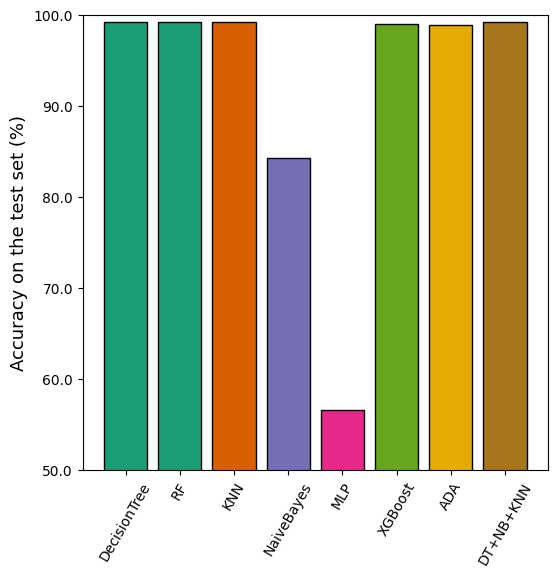

In [62]:
###############################################################################
# Plotting the results
# -----------------------
# Let's now evaluate the methods on the test set.
#
cmap = get_cmap('Dark2')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
fig, ax = plt.subplots(figsize=(6, 6.5))
pct_formatter = FuncFormatter(lambda x, pos: '{:.1f}'.format(x * 100))
ax.bar(np.arange(len(methods)),
       scores,
       color=colors,
       tick_label=titles,
       edgecolor='k')

ax.set_ylim(0.50, 1.00)
ax.set_ylabel('Accuracy on the test set (%)', fontsize=13)
ax.yaxis.set_major_formatter(pct_formatter)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
plt.subplots_adjust(bottom=0.18)
plt.show()

📈 Gerando Curvas ROC/AUC para todos os modelos...
🔍 Tipo de classificação detectado: Binária (2 classes)

🎯 Processando classificação binária...
📊 Processando DecisionTree...
   ✅ DecisionTree: AUC = 0.9974
📊 Processando RF...
   ✅ RF: AUC = 0.9984
📊 Processando KNN...
   ✅ KNN: AUC = 0.9942
📊 Processando NaiveBayes...
   ✅ NaiveBayes: AUC = 0.9228
📊 Processando MLP...
   ✅ MLP: AUC = 0.5000
📊 Processando XGBoost...
   ✅ XGBoost: AUC = 0.9990
📊 Processando ADA...
   ✅ ADA: AUC = 0.9982   ✅ ADA: AUC = 0.9982
📊 Processando DT+NB+KNN...
   ✅ DT+NB+KNN: AUC = 0.9972

📊 Processando DT+NB+KNN...
   ✅ DT+NB+KNN: AUC = 0.9972


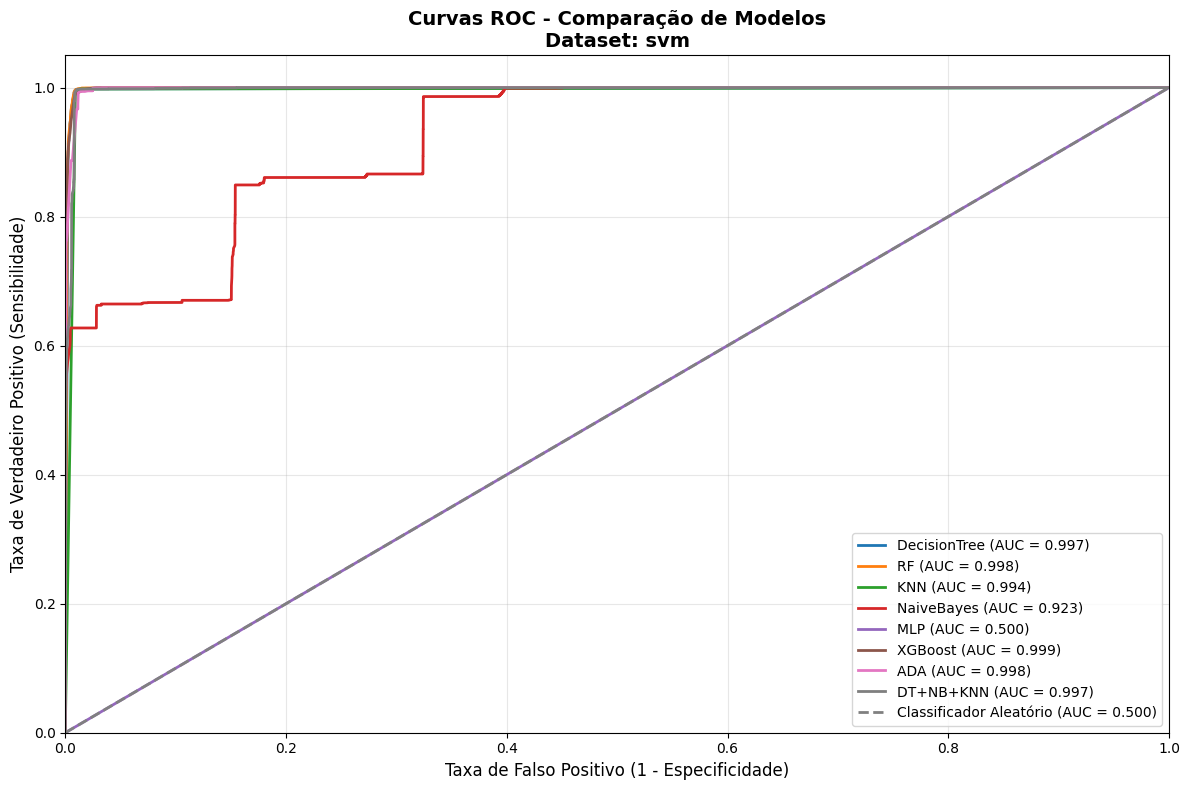


📊 Gerando gráfico de comparação dos scores AUC...


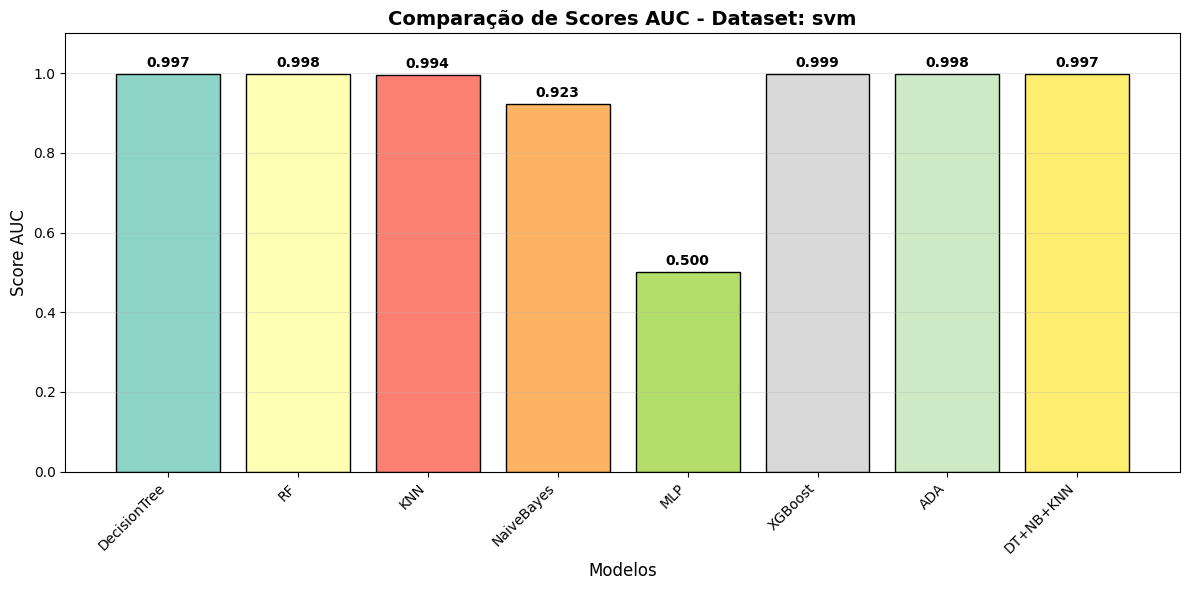


🏆 RESUMO DOS SCORES AUC:
✅ DecisionTree   : 0.9974
✅ RF             : 0.9984
✅ KNN            : 0.9942
✅ NaiveBayes     : 0.9228
✅ MLP            : 0.5000
✅ XGBoost        : 0.9990
✅ ADA            : 0.9982
✅ DT+NB+KNN      : 0.9972

🥇 RANKING POR AUC:
----------------------------------------
🥇 XGBoost        : 0.9990
🥈 RF             : 0.9984
🥉 ADA            : 0.9982
 4. DecisionTree   : 0.9974
 5. DT+NB+KNN      : 0.9972
 6. KNN            : 0.9942
 7. NaiveBayes     : 0.9228
 8. MLP            : 0.5000

📊 ESTATÍSTICAS AUC:
------------------------------
Melhor AUC: 0.9990 (XGBoost)
AUC Médio: 0.9259
Desvio Padrão: 0.1741

💡 DataFrame 'auc_df' disponível para análises adicionais.

🎉 Análise ROC/AUC completa para 8 modelos!


In [63]:
# Geração de Curvas ROC/AUC para todos os classificadores
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import cycle

print("📈 Gerando Curvas ROC/AUC para todos os modelos...")

# Verificar se é classificação binária ou multiclasse
n_classes = len(np.unique(y_test))
print(f"🔍 Tipo de classificação detectado: {'Binária' if n_classes == 2 else 'Multiclasse'} ({n_classes} classes)")

# Configurar cores para os gráficos
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Lista para armazenar os valores AUC
auc_scores = []

if n_classes == 2:
    # CLASSIFICAÇÃO BINÁRIA - ROC/AUC tradicional
    print("\n🎯 Processando classificação binária...")
    
    plt.figure(figsize=(12, 8))
    
    for clf, title, color in zip(methods, titles, colors):
        print(f"📊 Processando {title}...")
        
        try:
            # Obter probabilidades de predição (necessário para ROC)
            if hasattr(clf, "predict_proba"):
                y_score = clf.predict_proba(X_test)[:, 1]
            elif hasattr(clf, "decision_function"):
                y_score = clf.decision_function(X_test)
            else:
                print(f"   ⚠️ {title}: Modelo não suporta probabilidades - usando predições binárias")
                y_score = clf.predict(X_test)
            
            # Calcular curva ROC
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            auc_scores.append(roc_auc)
            
            # Plotar curva ROC
            plt.plot(fpr, tpr, color=color, lw=2, 
                    label=f'{title} (AUC = {roc_auc:.3f})')
            
            print(f"   ✅ {title}: AUC = {roc_auc:.4f}")
            
        except Exception as e:
            print(f"   ❌ Erro ao processar {title}: {e}")
            auc_scores.append(np.nan)
    
    # Adicionar linha diagonal (classificador aleatório)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
             label='Classificador Aleatório (AUC = 0.500)')
    
    # Configurar gráfico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo (1 - Especificidade)', fontsize=12)
    plt.ylabel('Taxa de Verdadeiro Positivo (Sensibilidade)', fontsize=12)
    plt.title(f'Curvas ROC - Comparação de Modelos\nDataset: {nome_dataset}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    # CLASSIFICAÇÃO MULTICLASSE - ROC/AUC One-vs-Rest
    print(f"\n🎯 Processando classificação multiclasse ({n_classes} classes)...")
    
    # Binarizar labels para One-vs-Rest
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    
    # Se só há 2 classes, LabelBinarizer retorna 1D - converter para 2D
    if y_test_bin.shape[1] == 1:
        y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])
    
    # Calcular número de subplots necessários
    n_models = len(methods)
    n_cols = 3  # 3 colunas por linha
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
    # Garantir que axes seja sempre um array 2D
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, (clf, title) in enumerate(zip(methods, titles)):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_models > 1 else axes
        
        print(f"📊 Processando {title}...")
        
        try:
            # Obter probabilidades de predição
            if hasattr(clf, "predict_proba"):
                y_score = clf.predict_proba(X_test)
            elif hasattr(clf, "decision_function"):
                y_score = clf.decision_function(X_test)
                # Normalizar scores para [0,1] se necessário
                if y_score.min() < 0:
                    y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
            else:
                print(f"   ⚠️ {title}: Modelo não suporta probabilidades")
                continue
            
            # Calcular ROC para cada classe (One-vs-Rest)
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                if y_score.shape[1] > i:  # Verificar se a classe existe
                    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])
            
            # Plotar ROC para cada classe
            class_colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
            for i, color in zip(range(n_classes), class_colors):
                if i in roc_auc:
                    ax.plot(fpr[i], tpr[i], color=color, lw=2,
                           label=f'Classe {i} (AUC = {roc_auc[i]:.3f})')
            
            # Calcular AUC médio
            mean_auc = np.mean(list(roc_auc.values())) if roc_auc else 0
            auc_scores.append(mean_auc)
            
            # Linha diagonal
            ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
            
            # Configurar subplot
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('Taxa de Falso Positivo')
            ax.set_ylabel('Taxa de Verdadeiro Positivo')
            ax.set_title(f'{title}\n(AUC Médio = {mean_auc:.3f})', fontweight='bold')
            ax.legend(loc="lower right", fontsize=8)
            ax.grid(True, alpha=0.3)
            
            print(f"   ✅ {title}: AUC Médio = {mean_auc:.4f}")
            
        except Exception as e:
            print(f"   ❌ Erro ao processar {title}: {e}")
            auc_scores.append(np.nan)
            
            # Plotar mensagem de erro
            ax.text(0.5, 0.5, f'Erro ao gerar\nROC para {title}', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=12, color='red')
            ax.set_title(f'Erro - {title}', color='red')
    
    # Ocultar subplots extras
    for idx in range(n_models, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if n_models > 1:
            axes[row, col].set_visible(False)
    
    plt.suptitle(f'Curvas ROC (One-vs-Rest) - Dataset: {nome_dataset}', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Gráfico de barras com scores AUC
print(f"\n📊 Gerando gráfico de comparação dos scores AUC...")

plt.figure(figsize=(12, 6))
valid_indices = [i for i, score in enumerate(auc_scores) if not np.isnan(score)]
valid_scores = [auc_scores[i] for i in valid_indices]
valid_titles = [titles[i] for i in valid_indices]

if valid_scores:
    colors_bar = plt.cm.Set3(np.linspace(0, 1, len(valid_scores)))
    bars = plt.bar(range(len(valid_scores)), valid_scores, color=colors_bar, 
                   edgecolor='black', linewidth=1)
    
    # Adicionar valores no topo das barras
    for i, (bar, score) in enumerate(zip(bars, valid_scores)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel('Modelos', fontsize=12)
    plt.ylabel('Score AUC', fontsize=12)
    plt.title(f'Comparação de Scores AUC - Dataset: {nome_dataset}', 
              fontsize=14, fontweight='bold')
    plt.xticks(range(len(valid_scores)), valid_titles, rotation=45, ha='right')
    plt.ylim(0, 1.1)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Resumo dos resultados
print(f"\n🏆 RESUMO DOS SCORES AUC:")
print("=" * 60)
auc_data = []
for title, score in zip(titles, auc_scores):
    if not np.isnan(score):
        auc_data.append({'modelo': title, 'auc_score': score})
        print(f"✅ {title:15s}: {score:.4f}")
    else:
        print(f"❌ {title:15s}: ERROR")

if auc_data:
    # Criar DataFrame com scores AUC
    auc_df = pd.DataFrame(auc_data)
    auc_df_sorted = auc_df.sort_values('auc_score', ascending=False).reset_index(drop=True)
    
    print(f"\n🥇 RANKING POR AUC:")
    print("-" * 40)
    for i, row in auc_df_sorted.iterrows():
        medal = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1:2d}."
        print(f"{medal} {row['modelo']:15s}: {row['auc_score']:.4f}")
    
    print(f"\n📊 ESTATÍSTICAS AUC:")
    print("-" * 30)
    print(f"Melhor AUC: {auc_df['auc_score'].max():.4f} ({auc_df.loc[auc_df['auc_score'].idxmax(), 'modelo']})")
    print(f"AUC Médio: {auc_df['auc_score'].mean():.4f}")
    print(f"Desvio Padrão: {auc_df['auc_score'].std():.4f}")
    
    # Disponibilizar DataFrame para uso posterior
    globals()['auc_df'] = auc_df
    print(f"\n💡 DataFrame 'auc_df' disponível para análises adicionais.")

print(f"\n🎉 Análise ROC/AUC completa para {len([s for s in auc_scores if not np.isnan(s)])} modelos!")